<center><p float="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/4_RGB_McCombs_School_Brand_Branded.png" width="300" height="100"/>
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>

<h1><center><font size=10>Data Science and Business Analytics</center></font></h1>
<h1><center>Unsupervised Learning: K-means Clustering - Week 1</center></h1>

<center><img src="https://images.pexels.com/photos/1454360/pexels-photo-1454360.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2" width="800" height="500"></center>

<b><h2><center>Engineering Colleges Case Study</center></h2></b>

## Problem Statement

### Context

Education is fast becoming a very competitive sector with hundreds of institutions to choose from. It is a life-transforming experience for any student and it has to be a thoughtful decision. There are ranking agencies that do a survey of all the colleges to provide more insights to students. Agency RankForYou wants to leverage this year's survey to roll out an editorial article in leading newspapers, on the state of engineering education in the country. Head of PR (Public Relations) comes to you, the data scientist working at RankForYou, and asks you to come up with evidence-based insights for that article.

### Objective

As a data scientist working at RankForYou, you have been asked to identify the different types of engineering colleges in the country to better understand the state of affairs. The key questions that need to be answered are:
- How many different types (clusters/segments) of colleges can be found from the data?
- How do these different groups of colleges differ from each other?
- Do you get slightly different solutions from two different techniques? How would you explain the difference?


### Data Description

The data contains survey results for 26 engineering colleges. The initial survey data has been summarized into a rating scale of 1-5 for different factors.

**Factor rating index**
 - 1 - Very low
 - 2 - Low
 - 3 - Medium
 - 4 - High
 - 5 - Very high

**Data Dictionary**
 - SR_NO: Serial Number
 - Engg_College: 26 Engineering colleges with pseudonyms A to Z
 - Teaching: Quality of teaching at the engineering college
 - Fees: Fees at the engineering college
 - Placements: Job placements after a student graduates from the engineering college
 - Internship: Student Internships at the engineering college
 - Infrastructure: Infrastructure of the engineering college

## Importing necessary libraries

In [30]:
# this will help in making the Python code more structured automatically (good coding practice)
#%load_ext nb_black

# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Reading the Dataset

In [31]:
# loading the dataset
data = pd.read_excel("Engineering Colleges Case Study.xlsx")

## Overview of the Dataset

The initial steps to get an overview of any dataset is to:
- observe the first few rows of the dataset, to check whether the dataset has been loaded properly or not
- get information about the number of rows and columns in the dataset
- find out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
- check the statistical summary of the dataset to get an overview of the numerical columns of the data

### Checking the shape of the dataset

In [32]:
data.shape

(26, 7)

* The dataset has 26 rows and 7 columns

### Displaying few rows of the dataset

In [33]:
# viewing a random sample of the dataset
data.sample(n=10, random_state=1)

,SR_NO,Engg_College,Teaching,Fees,Placements,Internship,Infrastructure
18,19,S,3,5,4,3,3
13,14,N,3,5,3,3,4
17,18,R,3,4,4,3,3
3,4,D,5,4,5,4,4
22,23,W,2,5,1,1,1
10,11,K,3,4,3,4,5
19,20,T,3,5,3,2,3
20,21,U,2,2,2,2,1
4,5,E,2,5,2,2,5
2,3,C,4,5,5,4,5


### Creating a copy of original data

In [34]:
# copying the data to another variable to avoid any changes to original data
df = data.copy()

In [35]:
# dropping the serial no. column as it does not provide any information
df.drop("SR_NO", axis=1, inplace=True)

### Checking the data types of the columns for the dataset

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Engg_College    26 non-null     object
 1   Teaching        26 non-null     int64 
 2   Fees            26 non-null     int64 
 3   Placements      26 non-null     int64 
 4   Internship      26 non-null     int64 
 5   Infrastructure  26 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 1.3+ KB


**Observations**

- *Engg_College* is a categorical variable with 26 levels that indicate each college's name.
- The 5 rating variables are of type *int* (integer).

### Statistical summary of the dataset

In [37]:
df.describe()

,Teaching,Fees,Placements,Internship,Infrastructure
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,2.807692,3.576923,2.884615,2.769231,3.384615
std,1.132051,1.331858,1.531716,1.242826,1.298520
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.250000,1.250000,2.000000,3.000000
50%,3.000000,4.000000,3.000000,2.000000,3.000000
75%,3.000000,5.000000,4.000000,4.000000,4.750000
max,5.000000,5.000000,5.000000,5.000000,5.000000


**Observations**

- The median value of fees is 4, indicating that most of the engineering colleges have high fees.
- The mean and median of other ratings lie between 2 and 3, except the mean infrastructure rating.

### Checking for missing values

In [38]:
# checking for missing values
df.isna().sum()

,0
Engg_College,0
Teaching,0
Fees,0
Placements,0
Internship,0
Infrastructure,0


- There are no missing values in our data

## Exploratory Data Analysis

### Univariate Analysis

In [39]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<ipython-input-39-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


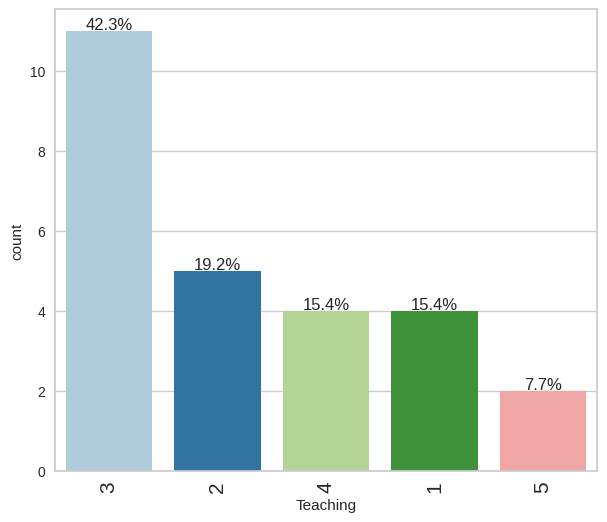

In [40]:
labeled_barplot(df, 'Teaching', perc=True)

<ipython-input-39-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


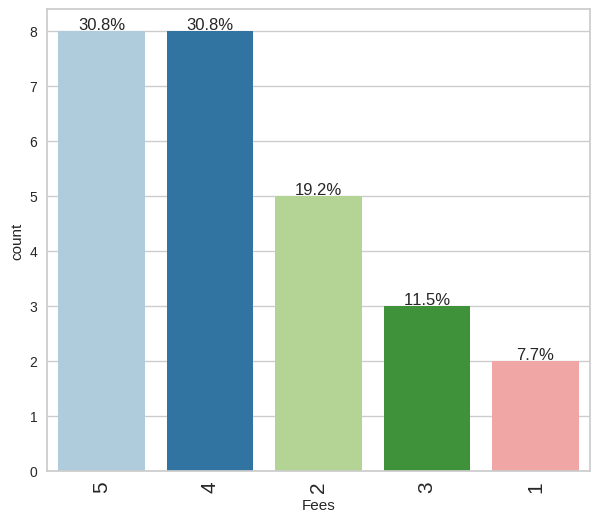

In [41]:
labeled_barplot(df, 'Fees', perc=True)

<ipython-input-39-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


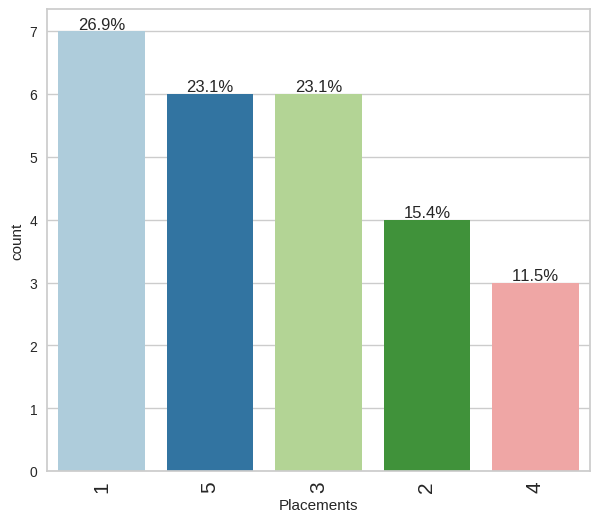

In [42]:
labeled_barplot(df, 'Placements', perc=True)

<ipython-input-39-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


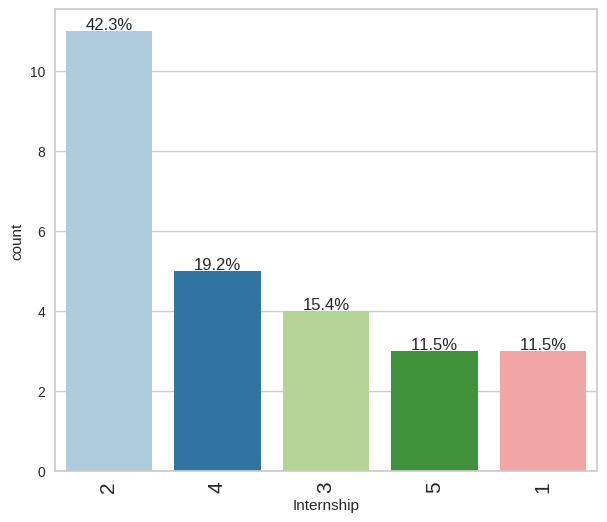

In [43]:
labeled_barplot(df, 'Internship', perc=True)

<ipython-input-39-0aaf8dec4340>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


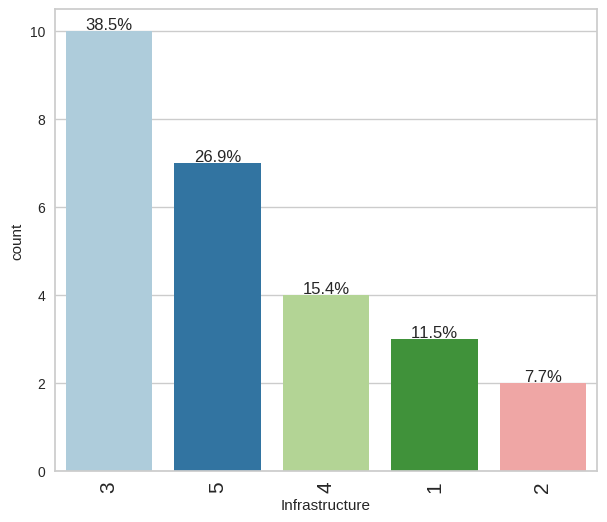

In [44]:
labeled_barplot(df, 'Infrastructure', perc=True)

**Observations**

- More than 65% of the colleges have a rating less than 4 for placements.
- More than 80% of the colleges have a rating of 3 or more for infrastructure.

### Bivariate Analsysis

#### Let's check for correlations

In [45]:
num_col = ['Teaching', 'Fees', 'Placements', 'Internship', 'Infrastructure']

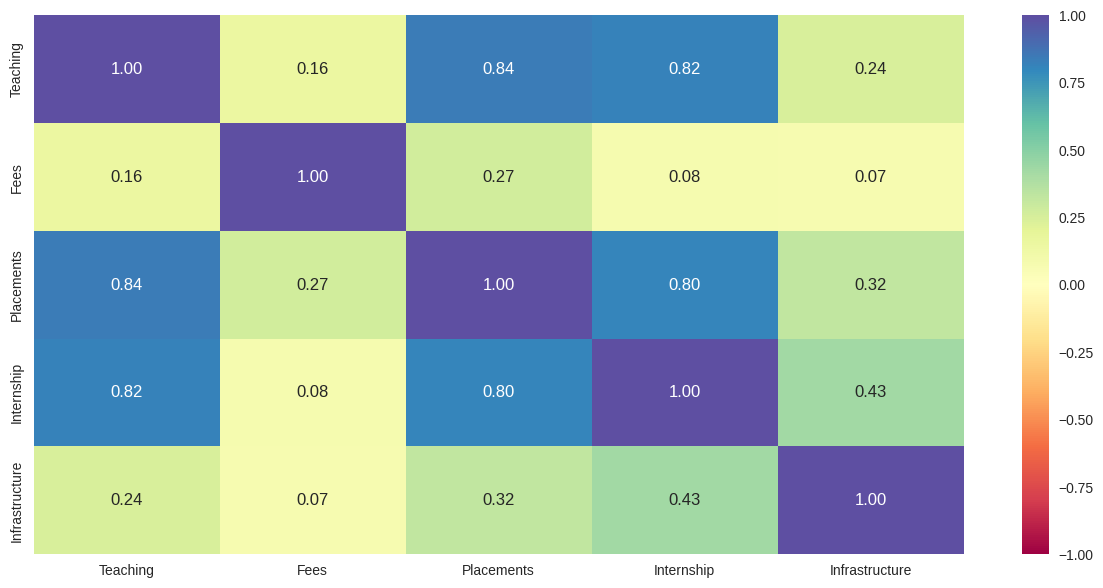

In [46]:
plt.figure(figsize=(15, 7))
sns.heatmap(df[num_col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observation**

- Rating for teaching is strongly positively correlated with the rating for placements and internships.
- This is obvious because if teaching quality is high, students are more likely to get placements and internships.

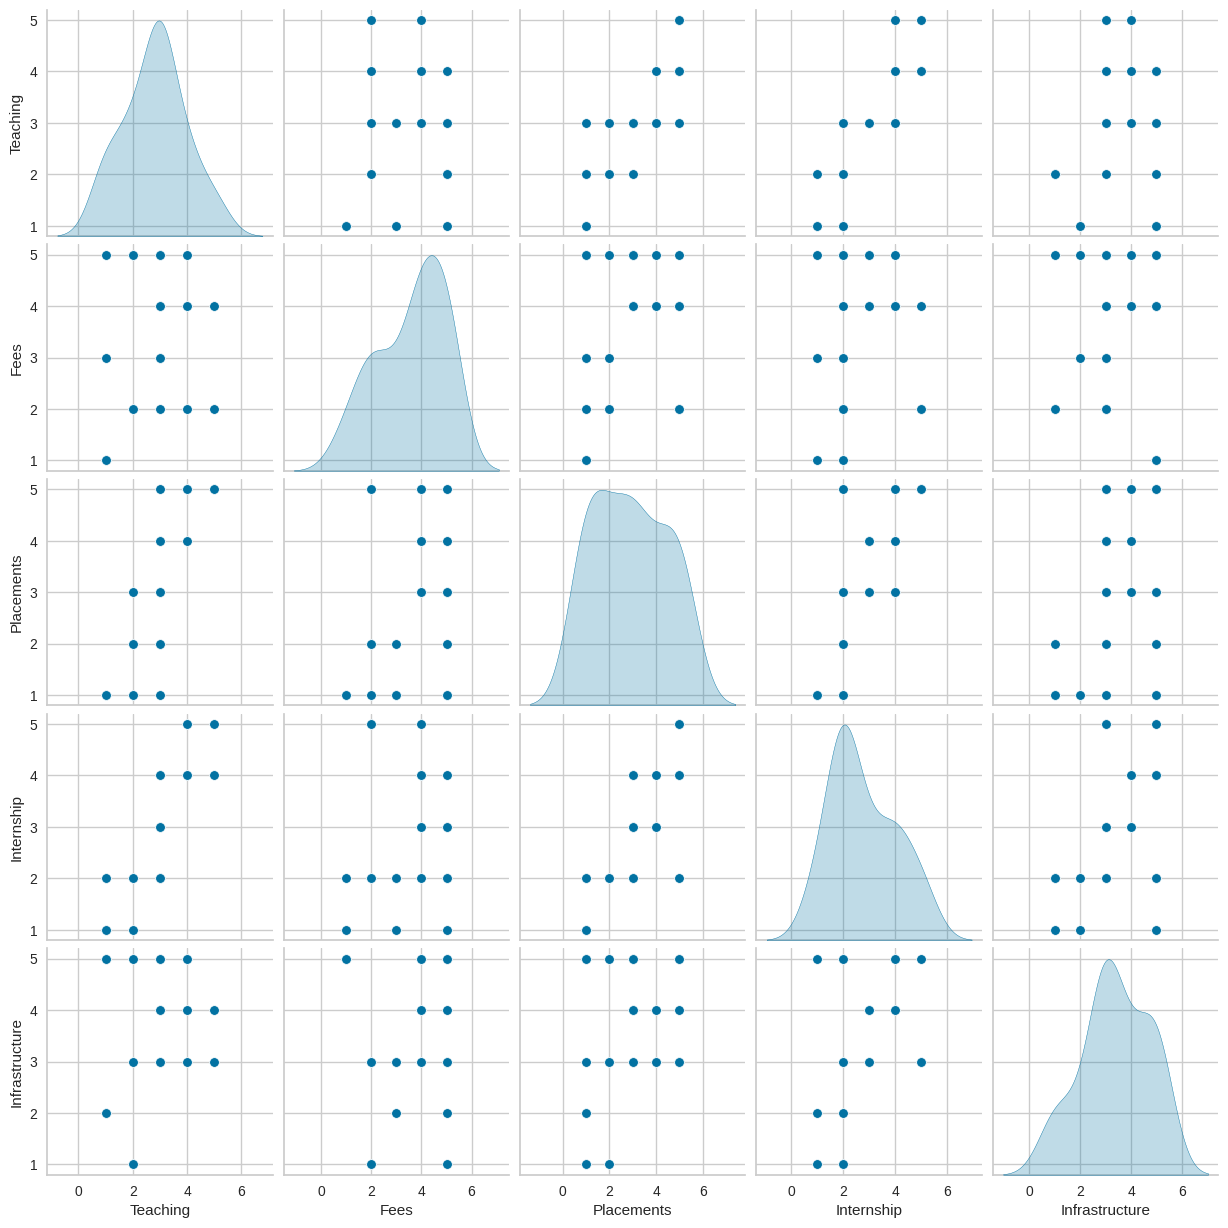

In [47]:
sns.pairplot(data=df[num_col], diag_kind="kde")
plt.show()

**Observations**

- Teaching is almost normally distributed.
- Distribution of fees seems to be bimodal.
- Distribution of Internships seems to be bimodal.

## Data Preprocessing

In [48]:
# Scaling the data set before clustering
scaler = StandardScaler()
subset = df[num_col].copy()
subset_scaled = scaler.fit_transform(subset)

In [49]:
# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

## K-means Clustering

Number of Clusters: 1 	Average Distortion: 2.087990295998642
Number of Clusters: 2 	Average Distortion: 1.6030760049686552
Number of Clusters: 3 	Average Distortion: 1.3542868697697457
Number of Clusters: 4 	Average Distortion: 1.1658645562214658
Number of Clusters: 5 	Average Distortion: 1.0290612283501503
Number of Clusters: 6 	Average Distortion: 0.9095886756490557
Number of Clusters: 7 	Average Distortion: 0.8046619356513329
Number of Clusters: 8 	Average Distortion: 0.7161563518185236


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

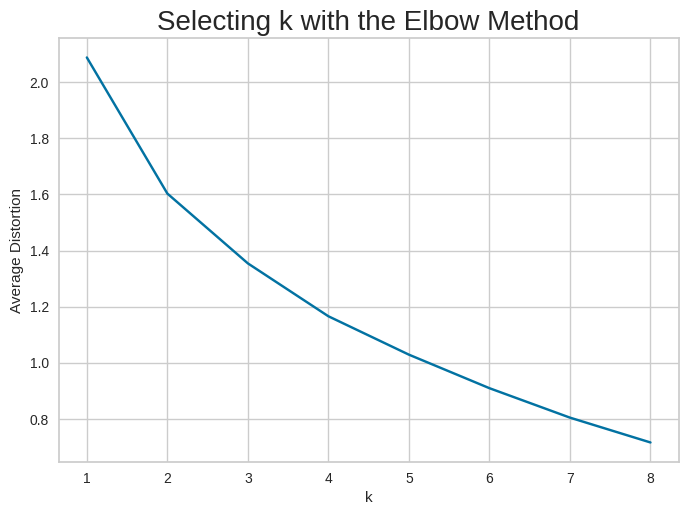

In [50]:
clusters = range(1, 9)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

**The appropriate value of k from the elbow curve seems to be 4 or 5.**

### Let's check the silhouette scores

For n_clusters = 2, silhouette score is 0.3347415593639785
For n_clusters = 3, silhouette score is 0.2896589939792401
For n_clusters = 4, silhouette score is 0.3490226771698325
For n_clusters = 5, silhouette score is 0.3578484211066675
For n_clusters = 6, silhouette score is 0.3751606440274479
For n_clusters = 7, silhouette score is 0.39463090921434624
For n_clusters = 8, silhouette score is 0.3975512934421172
For n_clusters = 9, silhouette score is 0.39102713851068926


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

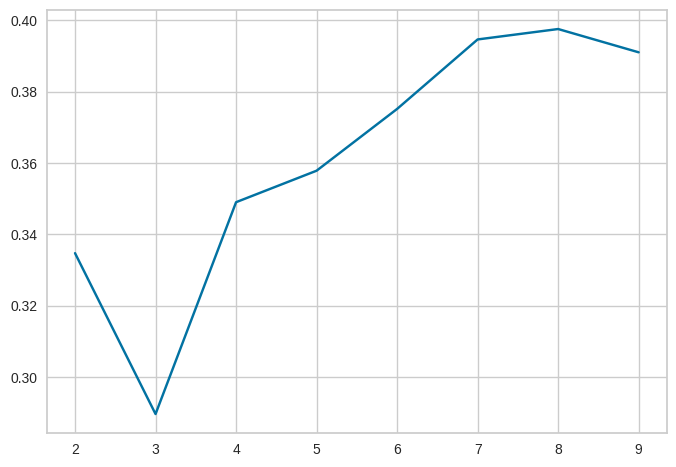

In [51]:
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)

**From the silhouette scores, it seems that 7 is a good value of k.**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


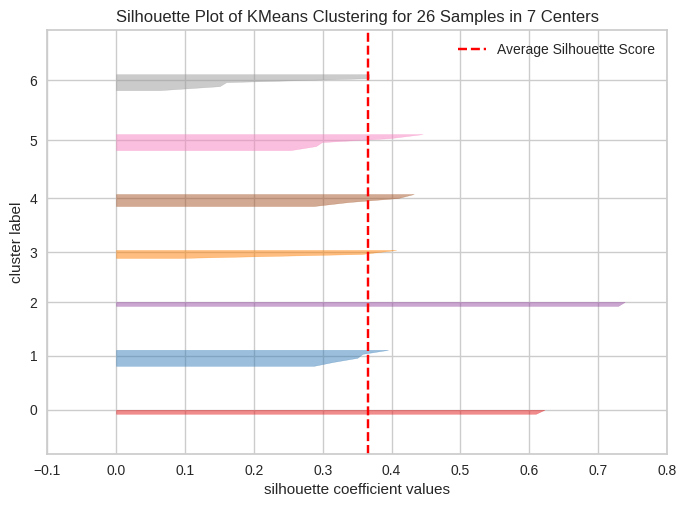

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 7 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [52]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(7, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


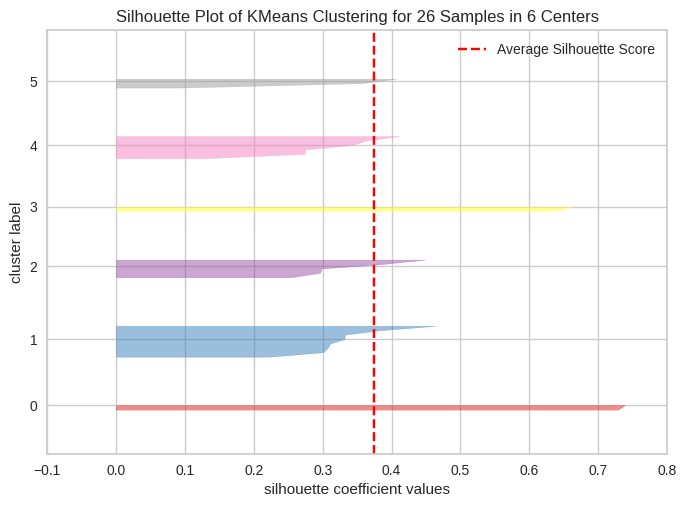

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [53]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


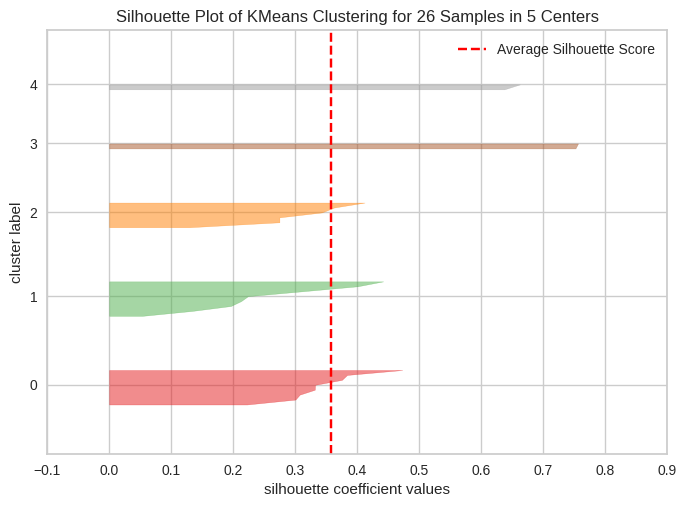

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [54]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


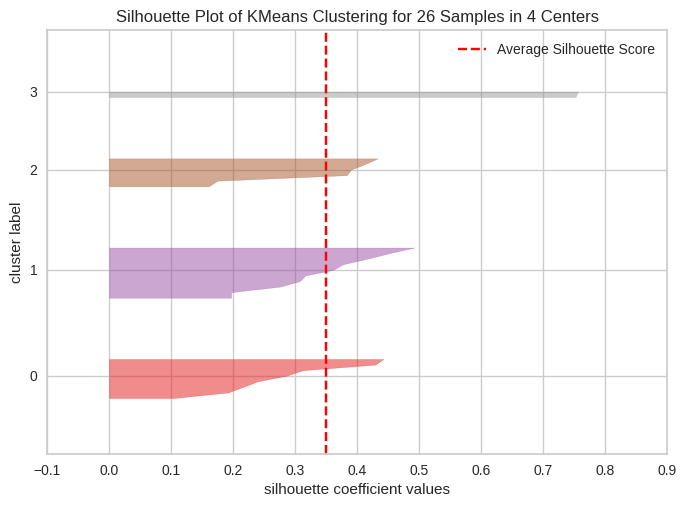

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 26 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [55]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

### Selecting final model

**Let's take 5 as the appropriate no. of clusters as the silhouette score is high enough and there is knick at 5 in the elbow curve.**

In [56]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(subset_scaled_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=0)

In [57]:
# adding kmeans cluster labels to the original dataframe
df["K_means_segments"] = kmeans.labels_

## Cluster Profiling

In [58]:
cluster_profile = df.groupby("K_means_segments").mean(numeric_only = True)

In [59]:
cluster_profile["count_in_each_segment"] = (
    df.groupby("K_means_segments")["Fees"].count().values
)

In [60]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Teaching,Fees,Placements,Internship,Infrastructure,count_in_each_segment
K_means_segments,,,,,,
0,1.000000,1.000000,1.000000,1.500000,5.000000,2
1,4.333333,3.500000,4.833333,4.500000,4.000000,6
2,2.600000,2.400000,1.600000,2.000000,2.200000,5
3,2.800000,4.500000,3.300000,2.800000,3.800000,10
4,1.333333,4.333333,1.000000,1.333333,1.666667,3


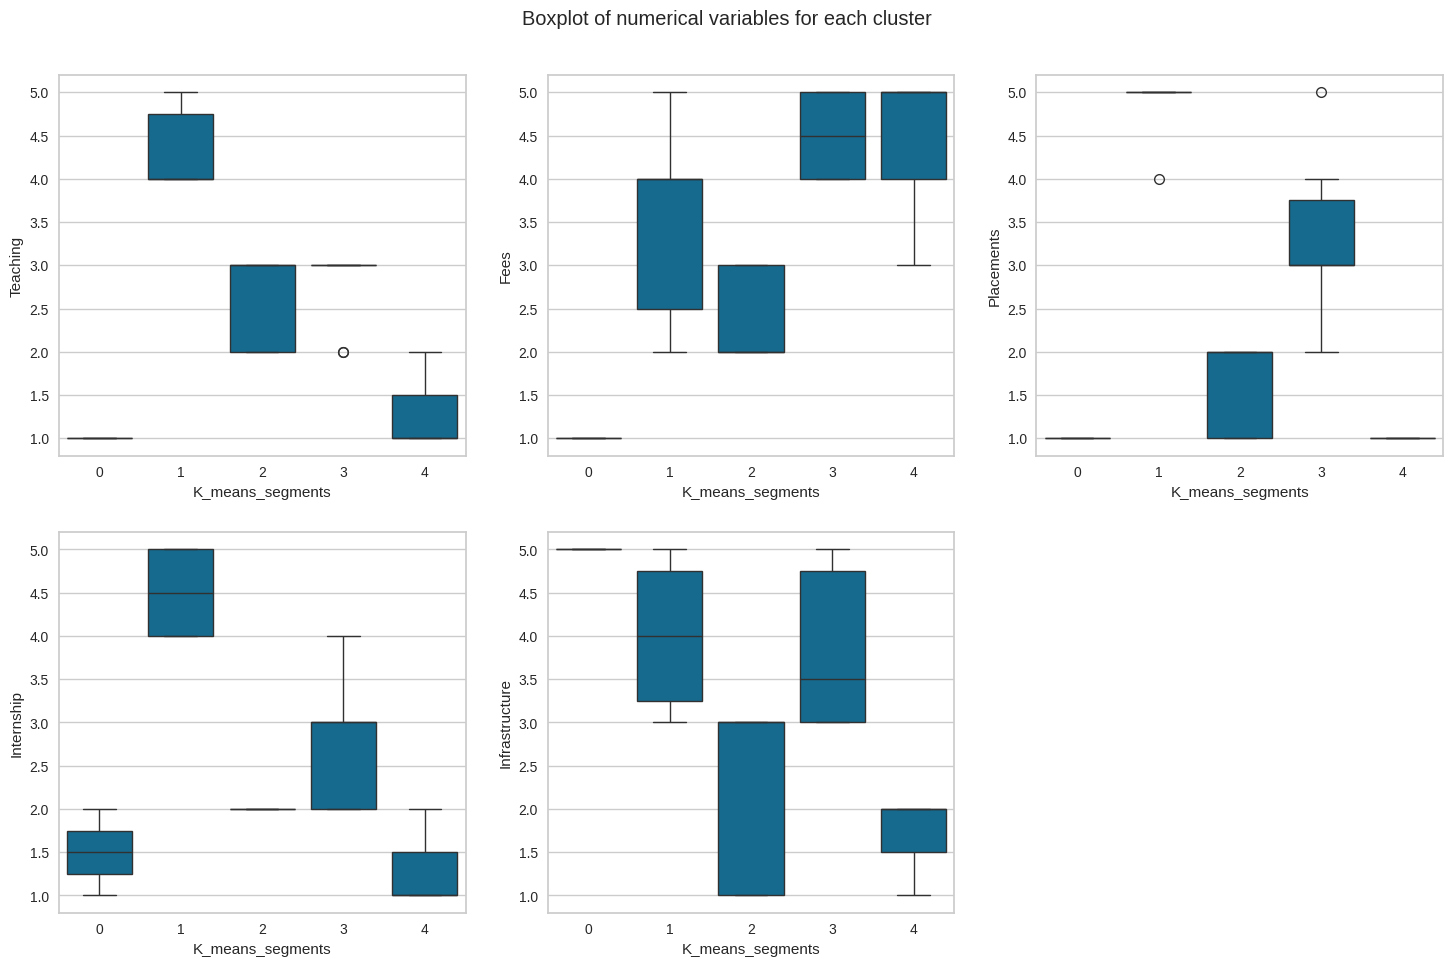

In [61]:
plt.figure(figsize=(15, 10))
plt.suptitle("Boxplot of numerical variables for each cluster")

for i, variable in enumerate(num_col):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, x="K_means_segments", y=variable)

plt.tight_layout(pad=2.0)

<Axes: xlabel='K_means_segments'>

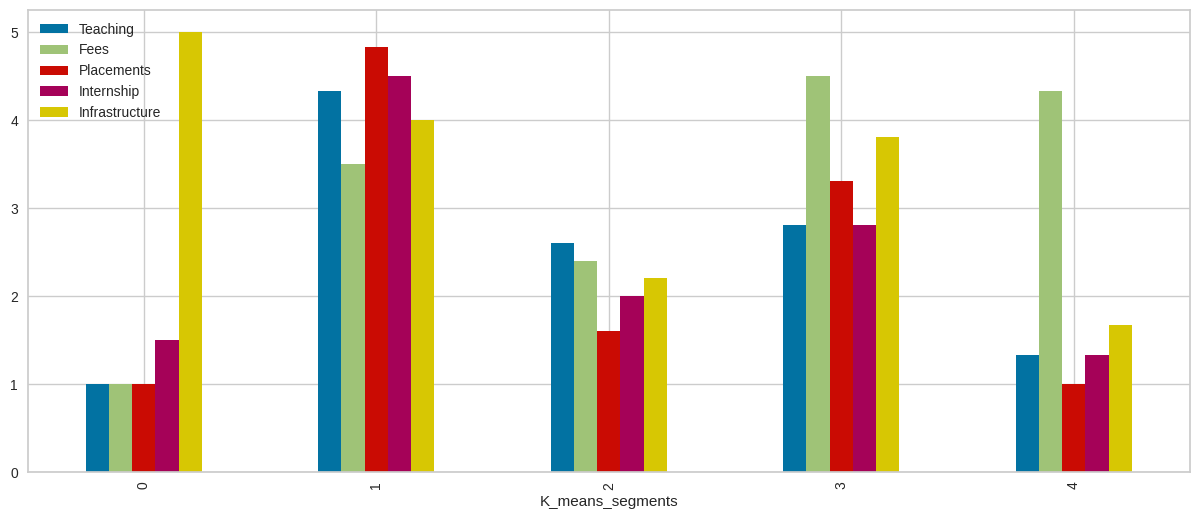

In [63]:
df.groupby("K_means_segments").mean(numeric_only = True).plot.bar(figsize=(15, 6))

### Insights

- **Cluster 0**:
    - Teaching ratings are high.
    - Fees are moderate for colleges in this cluster.
    - Placements ratings are very high.
    - Internship ratings are very high.
    - Infrastructure ratings are high to very high.


- **Cluster 1**:
    - Teaching ratings are low to moderate.
    - Fees are high for colleges in this cluster.
    - Placements ratings are very low.
    - Internship ratings are very low to low.
    - Infrastructure ratings are low to moderate.


- **Cluster 2**:
    - Teaching ratings are moderate.
    - Fees range from high to very high for colleges in this cluster.
    - Placements ratings are moderate to high, with a few lows and very highs.
    - Internship ratings are low to moderate.
    - Infrastructure ratings are moderate to high, with a few very highs.


- **Cluster 3**:
    - Teaching ratings are very low.
    - Fees are very low for colleges in this cluster.
    - Placements ratings are very low.
    - Internship ratings are very low to low.
    - Infrastructure ratings are very high.


- **Cluster 4**:
    - Teaching ratings are low to moderate.
    - Fees range from low to moderate for most colleges in this cluster.
    - Placements ratings are on the lower side.
    - Internship ratings are low.
    - Infrastructure ratings are low to moderate.

**Note:** The graphs and observations provided in the notebook are based on code execution with *sci-kit learn* version "1.0.2". In case a  mismatch between the plots and the associated insights is observed, it may be due to code execution on a different version of *sci-kit learn*, which might have resulted in a swapping of the clusters obtained.


## Business Insights and  Recommendations

- **Cluster 0**: These are the Tier 1 Colleges and have excellent teaching, placements & internships while maintaining a moderate infrastructure and moderate fees. **Corporates looking for the best candidates can approach this cluster for placements and internships.**


- **Cluster 2**: These are the Tier 2 Colleges which are just behind the Tier 1 colleges in terms of teaching and placements, but provide quite better infrastructure and are accordingly more expensive. **They have scope for improvements in teaching, placements, and internships, and should consider tie-ups with corporates and ed-tech and training organizations. Companies providing training programs to faculty and students should approach them.**


- **Cluster 3**: These are the Tier 3 colleges which have very high fees and very good infrastructure, but do not offer proper value-for-money in terms of teaching and internships. **This cluster of colleges will need to concentrate more towards onboarding better faculty and securing tie-ups with corporates to improve placement opportunities.**


- **Cluster 1** and **Cluster 4**: These are the poor performing colleges or new colleges. **These colleges will need to concentrate more on marketing and advertisements about their offerings to create awareness and attract students.**

___